In [1]:
import cv2
import random
import os
import dlib

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split

from math import *
from sklearn.preprocessing import LabelEncoder, StandardScaler
from collections import Counter
from itertools import repeat
import warnings

from sklearn.ensemble import StackingClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, classification_report

In [2]:
# Define functions to generate image file paths and combine them.
def generate_image_paths(directory, n=300):
    """
    Generate a list of file paths for images in a given directory.
    
    Args:
        directory (str): The path to the directory containing the images.
    
    Returns:
        List[str]: A list of file paths to the images in the directory.
    """
    image_paths = []
    paths = os.listdir(directory)
    for i in paths:
        if i != ".DS_Store":
            for j in os.listdir(os.path.join(directory, i))[:n]:
                imgPath = os.path.join(directory, i, j)
                image_paths.append(imgPath)
    return image_paths

In [3]:
def loadData(train_img):
    """
    Load a images from the train_img list.

    Args:
        train_img (List[str]): List of image file paths.

    Returns:
        List[np.ndarray]: List of loaded image in RGB format.
    """
    dataList = []
    for i in train_img:
        img = cv2.imread(i)
        if img is not None:
            sample = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            dataList.append(sample)
    return dataList

In [4]:
# Define the paths to the directories containing the train and test images.
trainDataDir = "./dataset/train/"
testDataDir = "./dataset/test/"

# Generate lists of image file paths for the train and test images.
train_image_paths = generate_image_paths(trainDataDir, 100)
test_image_paths = generate_image_paths(testDataDir, 100)

In [5]:
# Call the function to load images the train_img list.
# loading images
trainDataset = loadData(train_image_paths)
testDataset = loadData(test_image_paths)

In [6]:
print("Number of images in the dataset : Training:- {}, Testing:- {}".format(
    len(trainDataset), len(testDataset)))

Number of images in the dataset : Training:- 1100, Testing:- 1100


In [7]:
def displayData(train_img, className, num_samples=20, num_columns=5):
    """
    Load a specified number of random samples from the train_img list and display them in subplots.

    Args:
        train_img (List[np.ndarray]): List of loaded image samples as NumPy arrays.
        className (List[str]): List of class names corresponding to the images in train_img.
        num_samples (int): Number of random samples to display.
        num_columns (int): Number of columns for the subplot grid.

    Returns:
        List[np.ndarray]: List of loaded image samples as NumPy arrays.
    """
    # Randomly sample num_samples indices without replacement
    sampled_indices = random.sample(range(len(train_img)), num_samples)

    num_rows = (num_samples + num_columns - 1) // num_columns  # Calculate the number of rows required

    # Create a grid of subplots
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, 8))

    for i, ax in enumerate(axes.flat):
        if i < num_samples:
            idx = sampled_indices[i]
            ax.imshow(train_img[idx])
            ax.axis('off')
            ax.set_title(className[idx])

    # Remove any empty subplots
    for i in range(num_samples, num_rows * num_columns):
        fig.delaxes(axes.flatten()[i])
    
    plt.suptitle("Randomly Sampled Images")
    plt.tight_layout(rect=[0, 0.6, 1, 1])
    plt.show()
    return

In [8]:
train_image_labels = [i.split("/")[-2] for i in train_image_paths]
test_image_labels = [i.split("/")[-2] for i in test_image_paths]

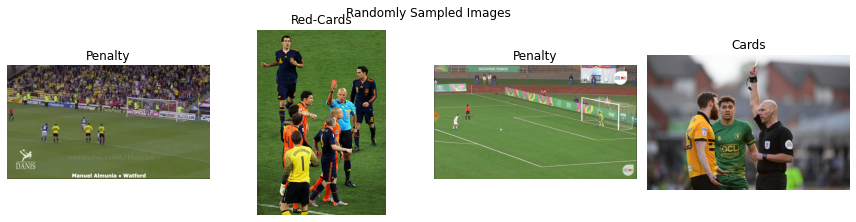

In [9]:
displayData(trainDataset, train_image_labels, num_samples=4, num_columns=4)

In [10]:
class ImagePreprocessor:
    def __init__(self):
        self.resized_images = []
        self.normalized_images = []
        self.gray_images = []
        self.brightness_contrast_images = []
        self.mean_noise_reduced_images = []
        self.three_noise_reduced_images = []
    
    def ensure_correct_channels(self, image):
        if image.shape[2] != 3:
            if image.shape[2] == 1:
                # Convert grayscale image to color (3 channels)
                image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
            else:
                raise ValueError("Input image should have 3 channels (color) or 1 channel (grayscale).")

        return image

    def resize(self, image):
        resized_img = cv2.resize(image, (100, 100))
        self.resized_images.append(resized_img)
        return resized_img

    def normalize(self, image):
        img_normalized = cv2.normalize(image, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        self.normalized_images.append(img_normalized)
        return img_normalized

    def convert_to_gray(self, image):
        gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        self.gray_images.append(gray_img)
        return gray_img

    def adjust_brightness_contrast(self, image, brightness=20, contrast=1):
        adjusted_img = cv2.convertScaleAbs(image, alpha=contrast, beta=brightness)
        self.brightness_contrast_images.append(adjusted_img)
        return adjusted_img

    def denoise_mean(self, image):
        filtered_img = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)
        self.mean_noise_reduced_images.append(filtered_img)
        return filtered_img

    def denoise_three(self, image):
        filtered_img = cv2.GaussianBlur(image, (5, 5), 0)
        self.three_noise_reduced_images.append(filtered_img)
        return filtered_img


In [11]:
# Create an instance of the ImagePreprocessor class
preprocessor = ImagePreprocessor()

In [12]:
# Loop through your list of images and apply the preprocessing steps
processedTrainImages = []
for image in trainDataset:
    image = preprocessor.ensure_correct_channels(image)
    resized = preprocessor.resize(image)
    normalized = preprocessor.normalize(resized)
    gray = preprocessor.convert_to_gray(normalized)
    brightness_contrast = preprocessor.adjust_brightness_contrast(gray)
    three_denoised = preprocessor.denoise_three(brightness_contrast)
    processedTrainImages.append(gray)

In [13]:
processedTestImages = []
for image in testDataset:
    image = preprocessor.ensure_correct_channels(image)
    resized = preprocessor.resize(image)
    normalized = preprocessor.normalize(resized)
    gray = preprocessor.convert_to_gray(normalized)
    brightness_contrast = preprocessor.adjust_brightness_contrast(gray)
    three_denoised = preprocessor.denoise_three(brightness_contrast)
    processedTestImages.append(gray)

In [14]:
print("shape of input and output training data are {}, {}".format(np.asarray(processedTrainImages).shape, len(train_image_labels)))

shape of input and output training data are (1100, 100, 100), 1100


In [15]:
print("shape of input and output testing data are {}, {}".format(np.asarray(processedTestImages).shape, len(train_image_labels)))

shape of input and output testing data are (1100, 100, 100), 1100


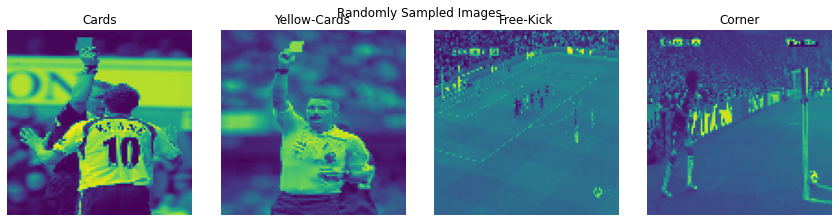

In [16]:
displayData(processedTrainImages,train_image_labels, num_samples=4, num_columns=4)


In [17]:
X_train = np.asarray(processedTrainImages).reshape(1100,10000)
X_test = np.asarray(processedTestImages).reshape(1100,10000)

In [18]:
# Standardize the features
scaler = StandardScaler()
x_train = scaler.fit_transform(X_train)
x_test = scaler.transform(X_test)

In [19]:
y_train = train_image_labels
y_test = test_image_labels

In [40]:
# defining model
# Stacking Classifier
estimators = [('lr', LogisticRegression()), ('bagging', BaggingClassifier())]
stacking_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stacking_model.fit(x_train, y_train)

stacking_pred = stacking_model.predict(x_test)

# Generate ROC curve and calculate AUC score
stacking_probs = stacking_model.predict_proba(x_test)[:, 1]


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    

In [25]:
# Bagging Classifier
bagging_model = BaggingClassifier()
bagging_model.fit(x_train, y_train)

bagging_pred = bagging_model.predict(x_test)

bagging_probs = bagging_model.predict_proba(x_test)[:, 1]

In [26]:
# Logistic Regression
lr_model = LogisticRegression()
lr_model.fit(x_train, y_train)

lr_pred = lr_model.predict(x_test)

lr_probs = lr_model.predict_proba(x_test)[:, 1]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [27]:
# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=1, criterion='entropy', random_state=3, max_depth=0.001)
rf_model.fit(x_train, y_train)
rf_pred = rf_model.predict(x_test)
rf_probs = rf_model.predict_proba(x_test)[:, 1]


In [28]:
# Calculate accuracy metrics
stacking_accuracy = accuracy_score(y_test, stacking_pred)
bagging_accuracy = accuracy_score(y_test, bagging_pred)
lr_accuracy = accuracy_score(y_test, lr_pred)
rf_accuracy = accuracy_score(y_test, rf_pred)


In [29]:
# Generate confusion matrix
stacking_cm = confusion_matrix(y_test, stacking_pred)
bagging_cm = confusion_matrix(y_test, bagging_pred)
lr_cm = confusion_matrix(y_test, lr_pred)
rf_cm = confusion_matrix(y_test, rf_pred)

In [32]:
# Calculate precision, recall, and F1-score
stacking_precision = precision_score(y_test, stacking_pred, average="weighted", pos_label='real')
bagging_precision = precision_score(y_test, bagging_pred, average="weighted", pos_label='real')
lr_precision = precision_score(y_test, lr_pred, average="weighted" , pos_label='real')
rf_precision = precision_score(y_test, rf_pred, average="weighted" , pos_label='real')


stacking_recall = recall_score(y_test, stacking_pred, average="weighted" , pos_label='real')
bagging_recall = recall_score(y_test, bagging_pred, average="weighted" , pos_label='real')
lr_recall = recall_score(y_test, lr_pred, average="weighted" , pos_label='real')
rf_recall = recall_score(y_test, rf_pred, average="weighted" , pos_label='real')


stacking_f1 = f1_score(y_test, stacking_pred, average="weighted" , pos_label='real')
bagging_f1 = f1_score(y_test, bagging_pred, average="weighted" , pos_label='real')
lr_f1 = f1_score(y_test, lr_pred, average="weighted" , pos_label='real')
rf_f1 = f1_score(y_test, rf_pred, average="weighted" , pos_label='real')


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1301: UserWarning: Note that pos_label (set to 'real') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1301: UserWarning: Note that pos_label (set to 'real') is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)
/Librar

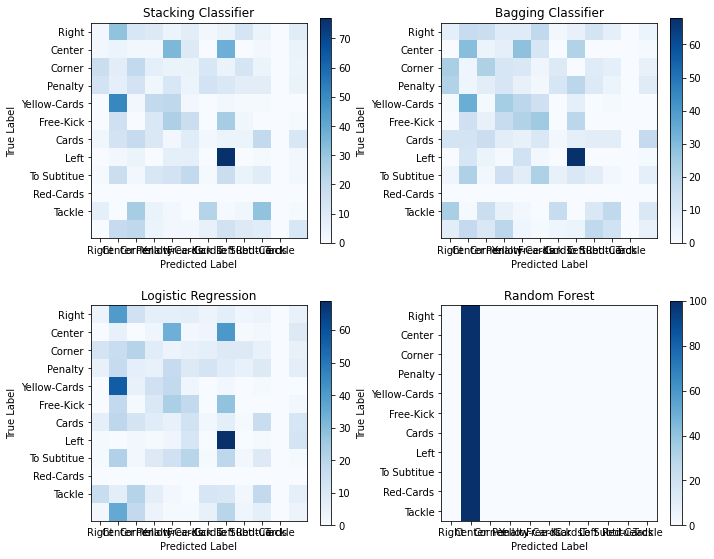

In [38]:
# Plot confusion matrix
def plot_confusion_matrix(cm, classes, title):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

plt.figure(figsize=(10, 8))
plt.subplot(221)
plot_confusion_matrix(stacking_cm, classes=list(set(y_train)), title='Stacking Classifier')
plt.subplot(222)
plot_confusion_matrix(bagging_cm, classes=list(set(y_train)), title='Bagging Classifier')
plt.subplot(223)
plot_confusion_matrix(lr_cm, classes=list(set(y_train)), title='Logistic Regression')
plt.subplot(224)
plot_confusion_matrix(rf_cm, classes=list(set(y_train)), title='Random Forest')
plt.tight_layout()
plt.show()

In [35]:
# Create accuracy tables
accuracy_table = pd.DataFrame({'Algorithm': ['Stacking Classifier', 'Bagging Classifier', 'Logistic Regression', 'Random Forest'],
                               'Accuracy': [stacking_accuracy, bagging_accuracy, lr_accuracy, rf_accuracy],
                              'Recall': [stacking_recall, bagging_recall, lr_recall, rf_recall],
                              'Precision': [stacking_precision, bagging_precision, lr_precision, rf_precision],
                               'F1 Score': [stacking_f1, bagging_f1, lr_f1, rf_f1]})
# Print accuracy tables
print("Accuracy Table:")
accuracy_table

Accuracy Table:


,Algorithm,Accuracy,Recall,Precision,F1 Score
0,Stacking Classifier,0.148182,0.148182,0.123135,0.126493
1,Bagging Classifier,0.176364,0.176364,0.145322,0.155796
2,Logistic Regression,0.134545,0.134545,0.111206,0.112580
3,Random Forest,0.090909,0.090909,0.008264,0.015152


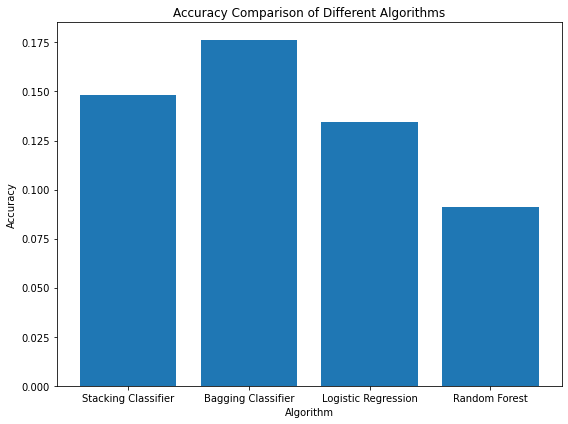

In [36]:
plt.figure(figsize=(8, 6))
plt.bar(accuracy_table['Algorithm'], accuracy_table['Accuracy'])
plt.xlabel('Algorithm')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Different Algorithms')
plt.tight_layout()
plt.show()
